# Twitter Climate Change Sentiment Analysis

- Author: Roelle Kim
- Date: 2022-04-05


# Load Packages and Data


In [10]:
# pip install pydataset

In [11]:
# import packages
import pandas as pd
import numpy as np
from os import makedirs
from os import path
import math
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import nltk.downloader
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.util import ngrams

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from pydataset import data
from sklearn.ensemble        import BaggingClassifier, \
         ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import RidgeClassifier
from sklearn.svm             import SVC
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

import pickle
import json

import kagglehub
from kagglehub import KaggleDatasetAdapter

# VADER Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import re
import warnings
warnings.filterwarnings("ignore")

In [12]:
file_path = "twitter_sentiment_data.csv"

df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "edqian/twitter-climate-change-sentiment-dataset",
    file_path,
)

In [13]:
# set up label dataframe for future refrences

label = [-1, 0, 1, 2]
labelN = ["Anti", "Neutral", "Pro", "News"]
labelDesc = [
    "the tweet does not believe in man-made climate change",
    "the tweet neither supports nor refutes the belief of man-made climate change",
    "the tweet supports the belief of man-made climate change",
    "the tweet links to factual news about climate change",
]

labelDf = pd.DataFrame(
    list(zip(label, labelN, labelDesc)), columns=["label", "name", "description"]
)

In [14]:
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting hustle as it was global warming but the p...,792927353886371840
1,1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world...",793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of cl...",793125156185137153


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  43943 non-null  int64 
 1   message    43943 non-null  object
 2   tweetid    43943 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


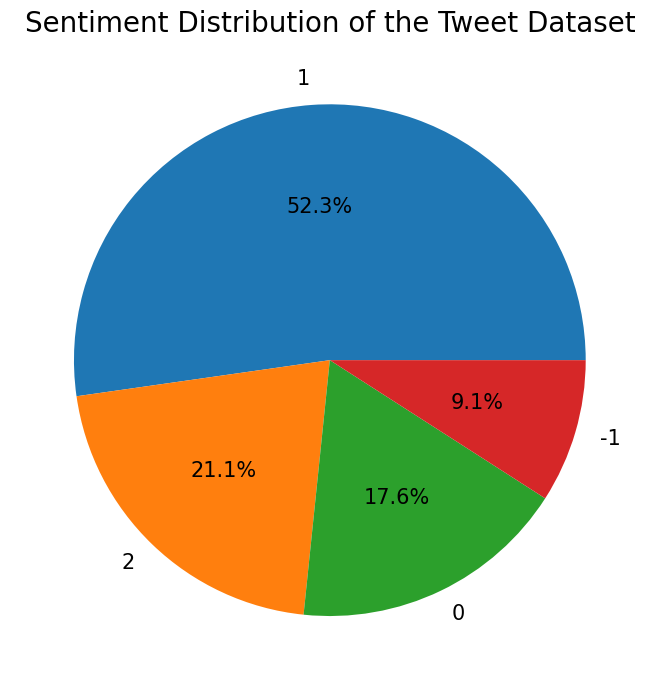

In [16]:
plt.figure(figsize=(7, 7))
plt.pie(
    df.sentiment.value_counts().values,
    labels=df.sentiment.value_counts().index,
    autopct="%2.1f%%",
    textprops={"fontsize": 15},
)
plt.title("Sentiment Distribution of the Tweet Dataset", fontsize=20)
plt.tight_layout()
plt.show()

In [17]:
df.sentiment.value_counts()

sentiment
 1    22962
 2     9276
 0     7715
-1     3990
Name: count, dtype: int64

# VADER Reclassification


In [ ]:
# Apply VADER to reclassify News tweets (label 2)
analyzer = SentimentIntensityAnalyzer()
news_tweets = df[df["sentiment"] == 2].copy()

vader_results = []
for idx, row in news_tweets.iterrows():
    scores = analyzer.polarity_scores(row["message"])
    compound = scores["compound"]
    vader_label = 1 if compound >= 0.05 else -1 if compound <= -0.05 else 0
    vader_results.append(
        {
            "index": idx,
            "original_message": row["message"],
            "vader_sentiment": vader_label,
            "compound_score": compound,
        }
    )

# Create vader_df for compound score ditribution
vader_df = pd.DataFrame(vader_results)

# Update dataset
df_updated = df.copy()
vader_mapping = dict(zip(vader_df["index"], vader_df["vader_sentiment"]))
for idx, vader_sentiment in vader_mapping.items():
    df_updated.loc[idx, "sentiment"] = vader_sentiment

print(f"Reclassified {len(vader_mapping)} news tweets")
print(
    "Final distribution:", df_updated["sentiment"].value_counts().sort_index().to_dict()
)

Reclassified 9276 news tweets
Final distribution: {-1: 7292, 0: 11108, 1: 25543}


In [76]:
vader_df.head(10)
# id.set_o/zption("display.max_colwidth", None)

,index,original_message,vader_sentiment,compound_score
0,4,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of cl...",-1,-0.2732
1,6,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of cl...",-1,-0.2732
2,7,RT @CCIRiviera: Presidential Candidate #DonaldTrump is Ã¢â‚¬Å“dangerousÃ¢â‚¬ï† on cli...,0,0.0000
3,14,RT @WorldResources: Reflections on Leonardo DiCaprioÃ¢â‚¬â„¢s new #climate change film...,0,0.0000
4,30,"Pentagon video about the future of cities predicts inequality, climate change, scarcit...",0,0.0000
5,41,L'Oreal named as global leader in climate change strategy #healthcare #comms #news htt...,0,0.0000
6,55,RT @ABCPolitics: .@realDonaldTrump vows to cancel 'billions' in climate change funds t...,-1,-0.2500
7,59,RT @ABCPolitics: .@realDonaldTrump vows to cancel 'billions' in climate change funds t...,-1,-0.2500
8,67,RT @grist: .@LeoDiCaprioÃ¢â‚¬â„¢s new climate change film is now streaming https://t.c...,0,0.0000
9,89,"#weather Mediterranean to become desert unless global warming limited to 1.5Ã‚Â°C, stu...",-1,-0.1779


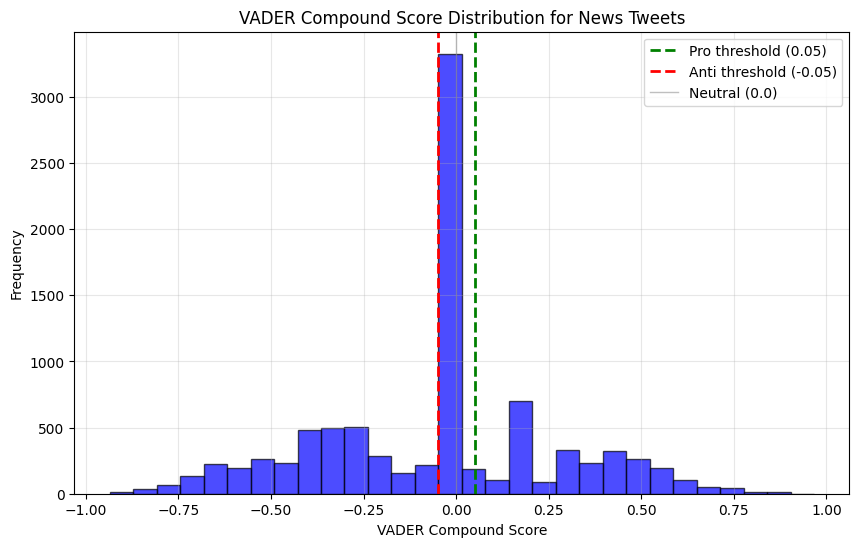

In [19]:
# VADER Compound Score Distribution
plt.figure(figsize=(10, 6))
plt.hist(vader_df["compound_score"], bins=30, alpha=0.7, color="blue", edgecolor="black")
plt.axvline(x=0.05, color="green", linestyle="--", linewidth=2, label="Pro threshold (0.05)")
plt.axvline(x=-0.05, color="red", linestyle="--", linewidth=2, label="Anti threshold (-0.05)")
plt.axvline(x=0, color="gray", linestyle="-", linewidth=1, alpha=0.5, label="Neutral (0.0)")
plt.xlabel("VADER Compound Score")
plt.ylabel("Frequency")
plt.title("VADER Compound Score Distribution for News Tweets")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [20]:
# Update the label dataframe to reflect the final dataset (no more News category)
label_updated = [-1, 0, 1]
labelN_updated = ["Anti", "Neutral", "Pro"]
labelDesc_updated = [
    "the tweet does not believe in man-made climate change",
    "the tweet neither supports nor refutes the belief of man-made climate change",
    "the tweet supports the belief of man-made climate change",
]

labelDf_updated = pd.DataFrame(
    list(zip(label_updated, labelN_updated, labelDesc_updated)),
    columns=["label", "name", "description"],
)
print(labelDf_updated.to_string(index=False))

 label    name                                                                  description
    -1    Anti                        the tweet does not believe in man-made climate change
     0 Neutral the tweet neither supports nor refutes the belief of man-made climate change
     1     Pro                     the tweet supports the belief of man-made climate change


# Data Preparation for Sentiment Analysis

Tweet texts will be transformed and vectorized to be fed into models.


In [21]:
# separate the messages column for transformation.
dfTweets = df_updated["message"]

In [22]:
dfTweets

0        @tiniebeany climate change is an interesting hustle as it was global warming but the p...
1        RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world...
2        Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https...
3        RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate...
4        RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of cl...
                                                   ...                                            
43938    Dear @realDonaldTrump,\nYeah right. Human Mediated Climate Change is a Chinese urban l...
43939          What will your respective parties do to prevent climate change globally? #ZPNDebate
43940    RT @MikkiL: UN Poll Shows Climate Change Is the Lowest of All Global Concerns https://...
43941    RT @taehbeingextra: i still can$q$t believe this gif of taehyung saved the human race,...
43942    @

## Tokenization

All the tweets are first split into arrays of words.


In [23]:
def createTokenizedArray(sentences):
    """
    Create lower case array of words with no punctuation.
    :param sentences: array or series of texts
    :return: lower case array of words with no punctuation.
    """
    # Initialize tokenizer and empty array to store modified sentences.
    tokenizer = RegexpTokenizer(r"\w+")
    tokenizedArray = []
    for i in range(0, len(sentences)):
        # Convert sentence to lower case.
        sentence = sentences[i].lower()

        # Split sentence into array of words with no punctuation.
        words = tokenizer.tokenize(sentence)

        # Append word array to list.
        tokenizedArray.append(words)

    # print(tokenizedArray)
    return tokenizedArray  # send modified contents back to calling function.

In [24]:
tokenizedLi = createTokenizedArray(dfTweets)

pd.Series(tokenizedLi[:5])

0    [tiniebeany, climate, change, is, an, interesting, hustle, as, it, was, global, warmin...
1    [rt, natgeochannel, watch, beforetheflood, right, here, as, leodicaprio, travels, the,...
2    [fabulous, leonardo, dicaprio, s, film, on, climate, change, is, brilliant, do, watch,...
3    [rt, mick_fanning, just, watched, this, amazing, documentary, by, leonardodicaprio, on...
4    [rt, cnalive, pranita, biswasi, a, lutheran, from, odisha, gives, testimony, on, effec...
dtype: object

Each array contains words of individual tweet.


## Stop Word Removal

Stop words are the words that do not add any significant values to the query search, such as "the", "a", and "an". They are safe to be removed from the tokenized list.


In [25]:
# To get stop words.
nltk.download("stopwords")


def removeStopWords(tokenList):
    """
    Create array of words with no punctuation or stop words.
    :param tokenList: tokenized list
    :return: array of words with no punctuation or stop words.
    """
    stopWords = set(stopwords.words("english"))
    shorterSentences = []  # Declare empty array of sentences.

    for sentence in tokenList:
        shorterSentence = []  # Declare empty array of words in single sentence.
        for word in sentence:
            if word not in stopWords:
                # Remove leading and trailing spaces.
                word = word.strip()

                # Ignore single character words and digits.
                if len(word) > 1 and word.isdigit() == False:
                    # Add remaining words to list.
                    shorterSentence.append(word)
        shorterSentences.append(shorterSentence)
    return shorterSentences

[nltk_data] Downloading package stopwords to /Users/nafis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
tokenizedNoStopLi = removeStopWords(tokenizedLi)

print(f"Sample sentence BEFORE removing stop words:\n{tokenizedLi[0]}")
print(f"\n\nSample sentence AFTER removing stop words:\n{tokenizedNoStopLi[0]}")

Sample sentence BEFORE removing stop words:
['tiniebeany', 'climate', 'change', 'is', 'an', 'interesting', 'hustle', 'as', 'it', 'was', 'global', 'warming', 'but', 'the', 'planet', 'stopped', 'warming', 'for', '15', 'yes', 'while', 'the', 'suv', 'boom']


Sample sentence AFTER removing stop words:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']


You can see the second set of the array now no longer contains some insignificant words such as "is", "an", "as" and "it".


## Stemming

English words are often time variations of a root word. Stemming rebuilds sentences by removing suffixes from words. It potentially improves the sentiment algorithm by accepting different words as one word as long as they were originated from the same stem.


In [27]:
def stemWords(sentenceArrays):
    """
    Removes suffixes and rebuilds the sentences.
    :param sentenceArrays: stentences list
    :return: array of sentences without suffixes
    """
    ps = PorterStemmer()
    stemmedSentences = []
    for sentenceArray in sentenceArrays:
        stemmedArray = []  # Declare empty array of words.
        for word in sentenceArray:
            stemmedArray.append(ps.stem(word))  # Add stemmed word.

        # Convert array back to sentence of stemmed words.
        delimeter = " "
        sentence = delimeter.join(stemmedArray)

        # Append stemmed sentence to list of sentences.
        stemmedSentences.append(sentence)
    return stemmedSentences

In [28]:
stemmedLi = stemWords(tokenizedNoStopLi)

print(f"Sample sentence BEFORE stemming:\n{tokenizedNoStopLi[0]}")
print(f"\nSample sentence AFTER stemming:\n{stemmedLi[0]}")

Sample sentence BEFORE stemming:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']

Sample sentence AFTER stemming:
tiniebeani climat chang interest hustl global warm planet stop warm ye suv boom


You can see the sentence after stemming has lost some suffixes. "Change" became "chang", "interesting" became "interest" and "warming" became "warm". The array of words has also been converted back to one full sentence.


## Vectorization

Now the stemmed sentences will be vectorized. It essentially transforms all the existing words into numbers so they can be fed to various big data algorithms.


In [29]:
def vectorizeList(stemmedList, ngramRangeStart, ngramRangeEnd):
    """
    Creates a matrix of word vectors.
    :param stemmedList: stemmed sentence list
    :return: matrix of word vectors and vocabulary dictionary
    """
    cv = CountVectorizer(binary=True, ngram_range=(ngramRangeStart, ngramRangeEnd))
    cv.fit(stemmedList)
    X = cv.transform(stemmedList)

    return X, cv.vocabulary_

In [30]:
vectorizedTweets, vectorDictionary = vectorizeList(stemmedLi, 1, 1)

Let's look into 2 different sample sentences to understand better what vectorization does


In [31]:
print(f"Sample sentence #1:\n{stemmedLi[0]}")
print(f"Sample sentence #2:\n{stemmedLi[1]}")

Sample sentence #1:
tiniebeani climat chang interest hustl global warm planet stop warm ye suv boom
Sample sentence #2:
rt natgeochannel watch beforetheflood right leodicaprio travel world tackl climat chang http co lkdehj3tnn httã


Notice these 2 sentences have a couple of words in common - "climat", "chang"


In [32]:
print(f"\n#1 after vectorization:\n{vectorizedTweets[0]}")
print(f"#2 after vectorization:\n{vectorizedTweets[1]}")


#1 after vectorization:
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 12 stored elements and shape (1, 67195)>
  Coords	Values
  (0, 10652)	1
  (0, 12943)	1
  (0, 13774)	1
  (0, 24524)	1
  (0, 27759)	1
  (0, 29419)	1
  (0, 45475)	1
  (0, 54598)	1
  (0, 55193)	1
  (0, 57219)	1
  (0, 61855)	1
  (0, 64839)	1
#2 after vectorization:
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 15 stored elements and shape (1, 67195)>
  Coords	Values
  (0, 9419)	1
  (0, 12943)	1
  (0, 13774)	1
  (0, 14222)	1
  (0, 27583)	1
  (0, 27591)	1
  (0, 35060)	1
  (0, 35653)	1
  (0, 40355)	1
  (0, 49581)	1
  (0, 50386)	1
  (0, 55654)	1
  (0, 57882)	1
  (0, 61927)	1
  (0, 63129)	1


In [33]:
vectorizedTweets.shape

(43943, 67195)

# N-Gram Analysis


In [34]:
def generateWordList(wordDf, sentimentScore, n_gram_size):
    resultDf = wordDf[(wordDf["sentiment"] == sentimentScore)]

    sentences = [sentence.split() for sentence in resultDf["transformedTweets"]]
    wordArray = []
    for i in range(0, len(sentences)):
        wordArray += sentences[i]

    counterList = Counter(ngrams(wordArray, n_gram_size)).most_common(80)

    counterDf = pd.DataFrame()

    delimiter = " "
    print(f"\n***N-Gram (Sentiment: {sentimentScore})")
    for i in range(0, len(counterList)):
        counterDict = {
            "N-Gram": delimiter.join(counterList[i][0]),
            "Occurrences": counterList[i][1],
        }
        # convert dict to series before concating to the dataframe.
        counterDict = pd.DataFrame(counterDict, index=[0])
        counterDf = pd.concat([counterDf, counterDict], ignore_index=True)

    return counterDf

In [35]:
# N-Gram variables
SIZE = 2
# add transformedTweets column to the updated dataset with the stemmed data.
df_updated["transformedTweets"] = stemmedLi
dfSub = df_updated[["sentiment", "transformedTweets"]]


***N-Gram (Sentiment: -1)


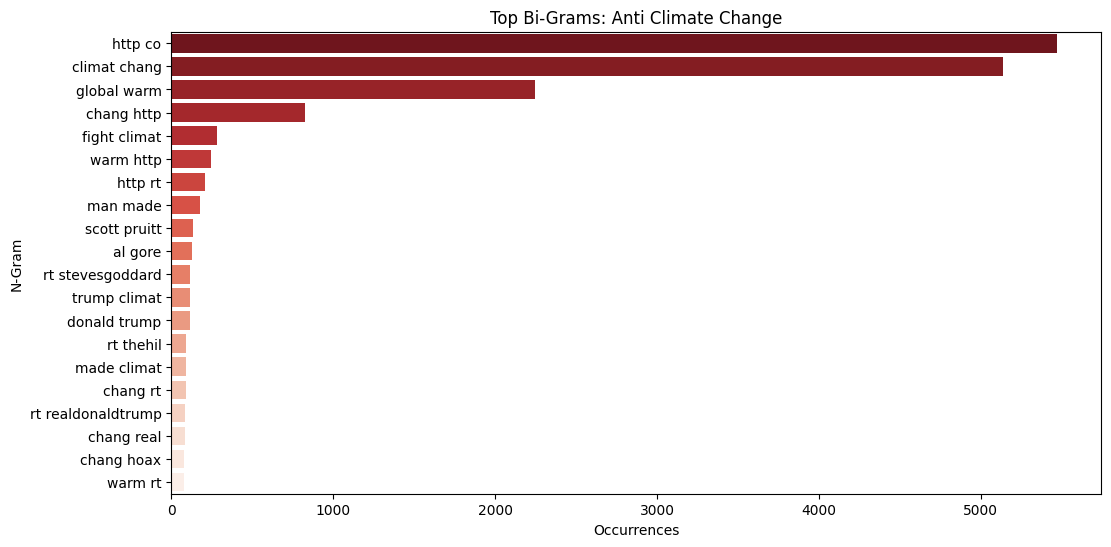

In [36]:
# Anti sentiment bi-grams
counterDfAntiTop = generateWordList(dfSub, -1, SIZE).head(20)
plt.figure(figsize=(12, 6))
plt.title("Top Bi-Grams: Anti Climate Change")
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="Reds_r")
plt.show()


***N-Gram (Sentiment: 0)


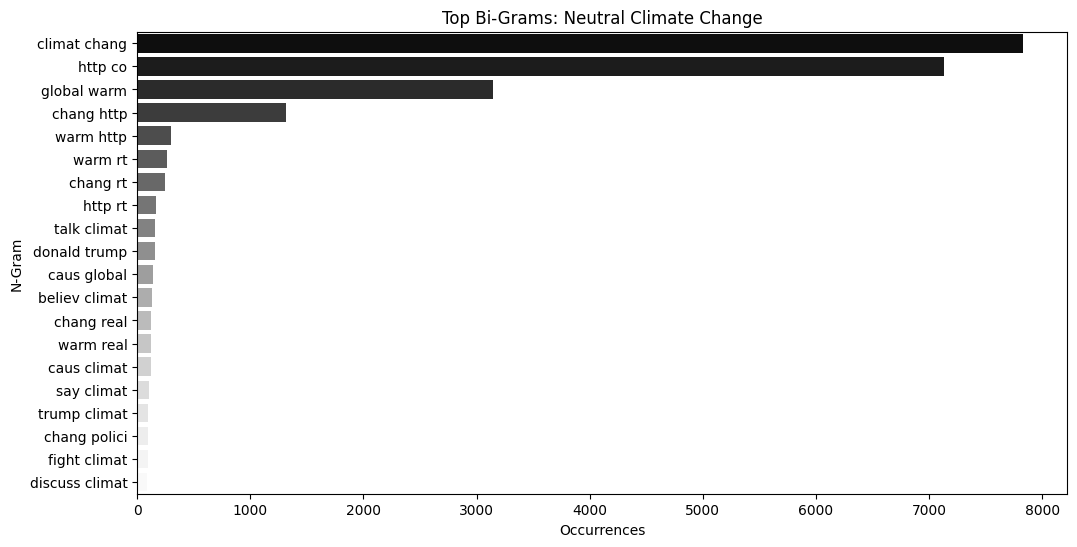

In [37]:
# Neutral sentiment bi-grams
counterDfNeutralTop = generateWordList(dfSub, 0, SIZE).head(20)
plt.figure(figsize=(12, 6))
plt.title("Top Bi-Grams: Neutral Climate Change")
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="Greys_r")
plt.show()


***N-Gram (Sentiment: 1)


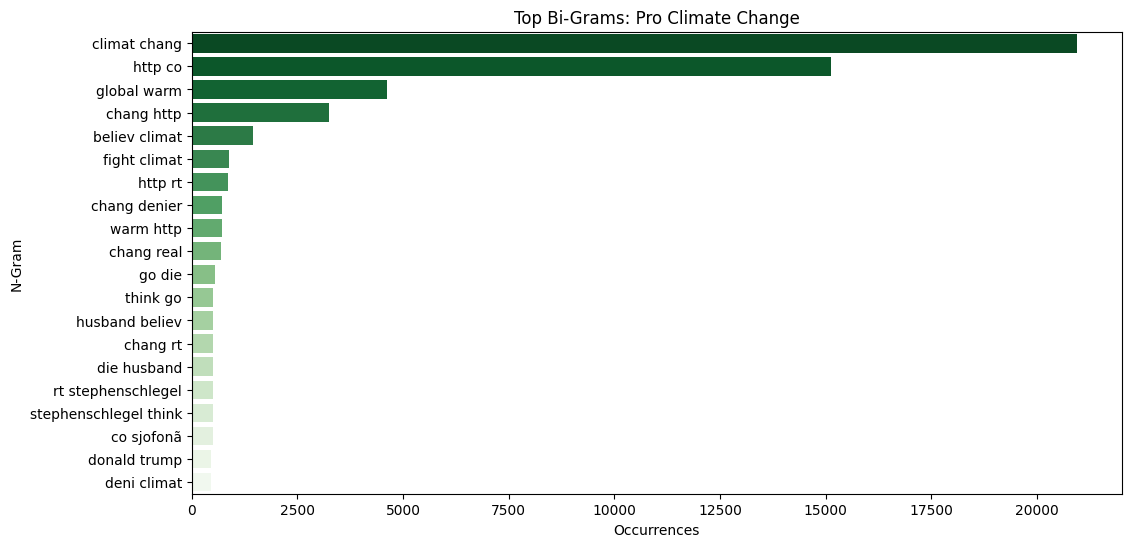

In [38]:
# Pro sentiment bi-grams
counterDfProTop = generateWordList(dfSub, 1, SIZE).head(20)
plt.figure(figsize=(12, 6))
plt.title("Top Bi-Grams: Pro Climate Change")
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="Greens_r")
plt.show()

Again, the top 3 bi-grams are "climat chang", "http co" and "global warm" for pro climate change tweets. A considerable size of tweets are containing "believ climat" and "fight climat". Perhaps people were explicitly expressing that they are "believing in climate change" or "fighting for the climate change".


## Tri-Grams

Let's try tri-grams and see if it finds more meaningful combinations of words than bi-grams.


In [39]:
SIZE = 3

## Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets (-1)



***N-Gram (Sentiment: -1)
                 N-Gram  Occurrences
0     climat chang http          823
1         chang http co          799
2    fight climat chang          283
3      global warm http          242
4          warm http co          235
5    trump climat chang          118
6       climat chang rt           85
7     climat chang real           84
8     made climat chang           84
9       man made climat           80
10    climat chang hoax           77
11       global warm rt           75
12     due climat chang           73
13     made global warm           72
14           http co rt           72
15      man made global           68
16     caus global warm           67
17  believ climat chang           66
18     say climat chang           66
19     global warm hoax           62


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

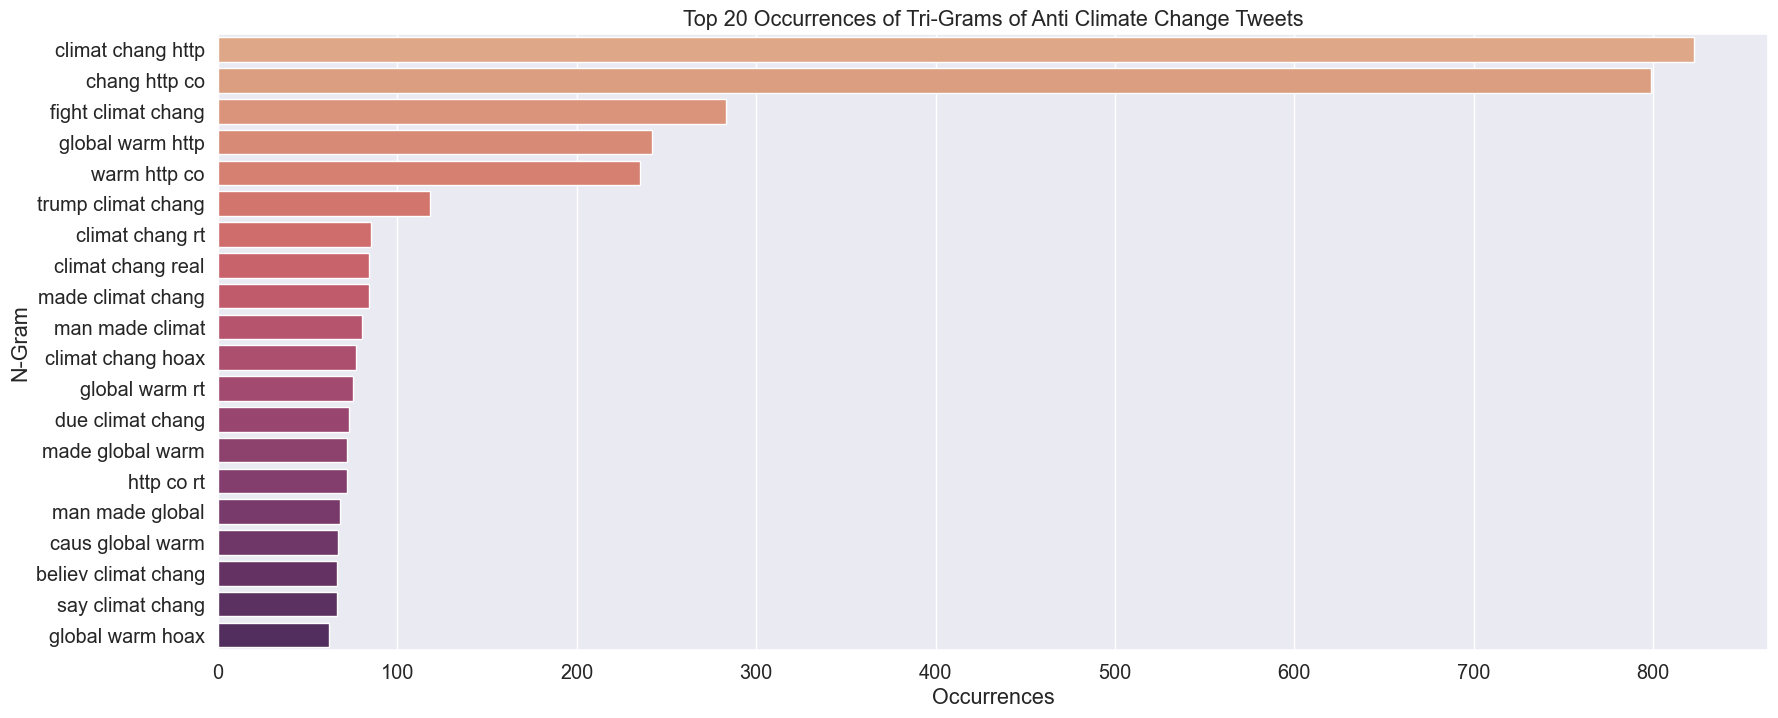

In [40]:
counterDfAntiTop = generateWordList(dfSub, -1, SIZE)
counterDfAntiTop = counterDfAntiTop.head(20)
print(counterDfAntiTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title("Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets")
sns.set_style("darkgrid")
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")

### Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets (0)



***N-Gram (Sentiment: 0)
                  N-Gram  Occurrences
0      climat chang http         1310
1          chang http co         1280
2       global warm http          296
3           warm http co          287
4         global warm rt          263
5        climat chang rt          248
6      talk climat chang          159
7       caus global warm          139
8    believ climat chang          131
9      climat chang real          122
10      global warm real          121
11     caus climat chang          120
12      say climat chang          103
13    trump climat chang           99
14   climat chang polici           93
15    fight climat chang           91
16  discuss climat chang           91
17      due climat chang           88
18    tackl climat chang           83
19     think global warm           81


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

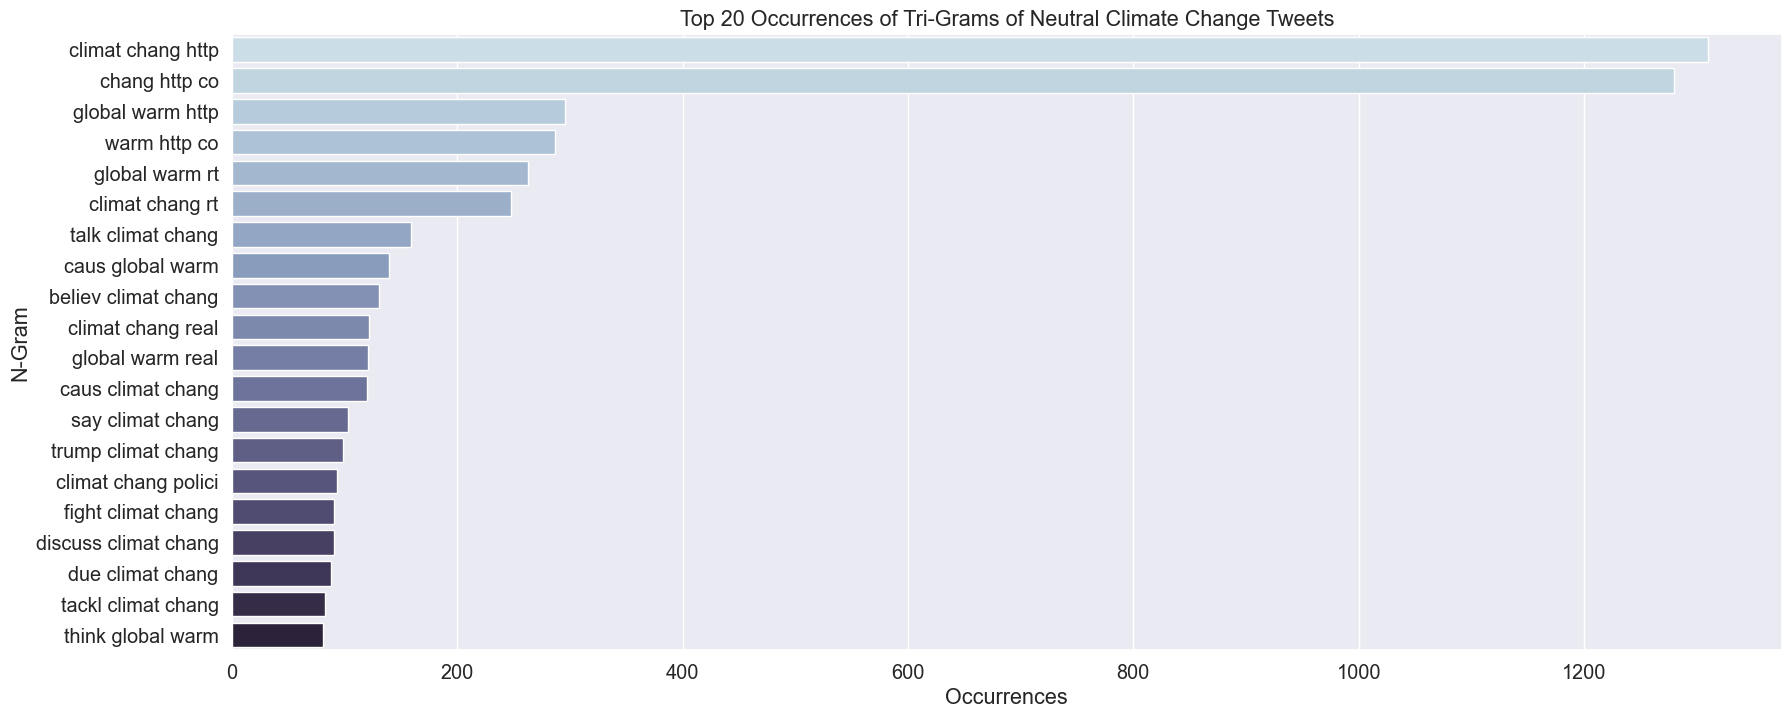

In [41]:
counterDfNeutral = generateWordList(dfSub, 0, SIZE)
counterDfNeutralTop = counterDfNeutral.head(20)
print(counterDfNeutralTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title("Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets")
sns.set_style("darkgrid")
sns.barplot(
    x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="ch:s=.25,rot=-.25"
)

### Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets (1)



***N-Gram (Sentiment: 1)
                      N-Gram  Occurrences
0          climat chang http         3242
1              chang http co         3082
2        believ climat chang         1436
3         fight climat chang          874
4        climat chang denier          717
5           global warm http          692
6          climat chang real          691
7               warm http co          680
8      husband believ climat          512
9               think go die          510
10            go die husband          510
11        die husband believ          510
12  rt stephenschlegel think          507
13  stephenschlegel think go          507
14           http co sjofonã          506
15           climat chang rt          497
16        tackl climat chang          432
17         deni climat chang          430
18             co sjofonã rt          429
19       combat climat chang          391


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

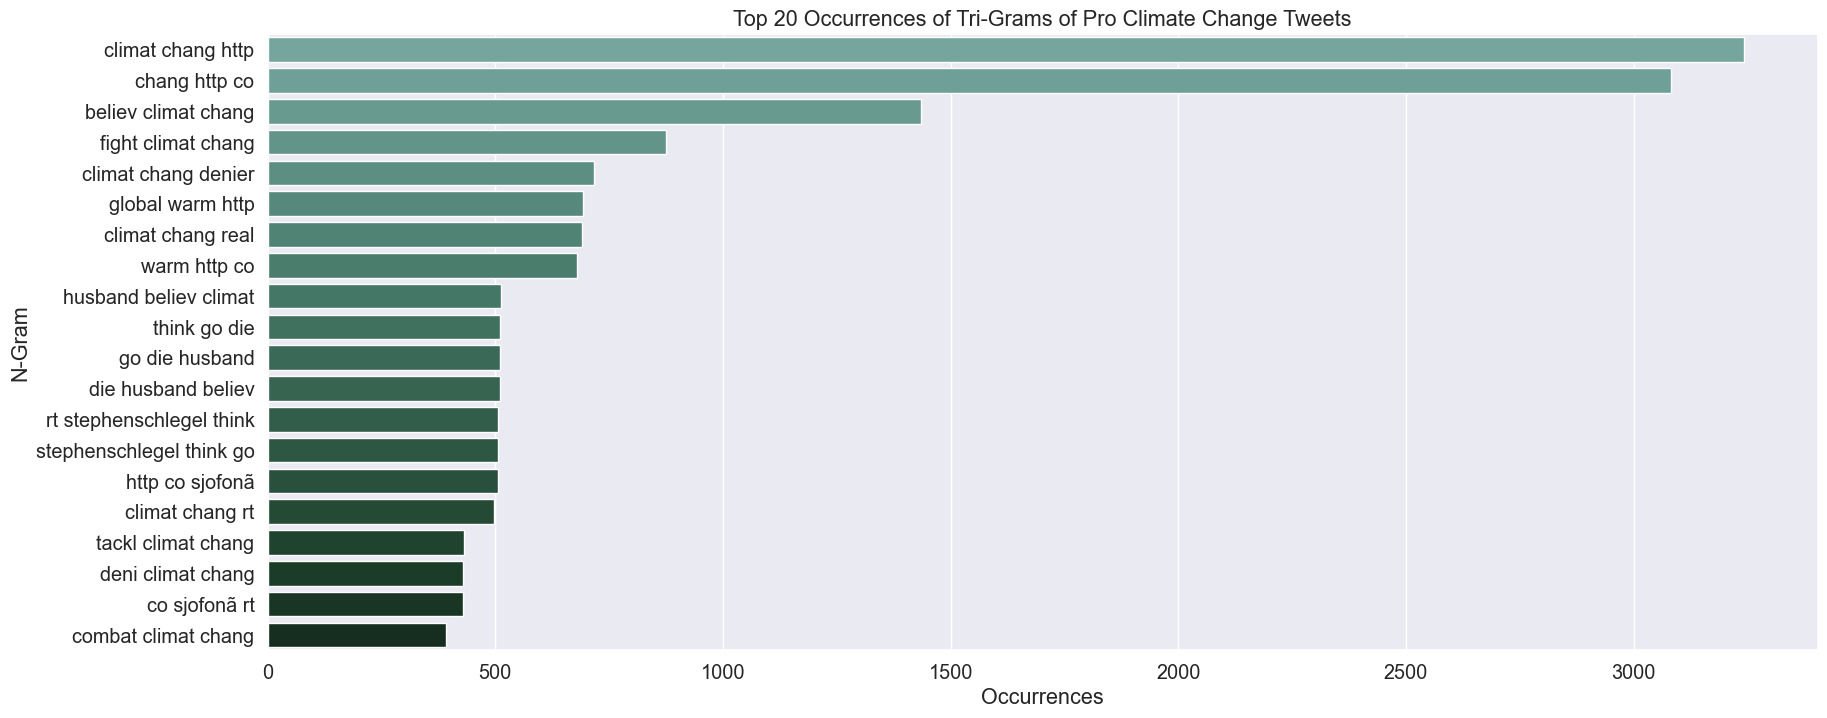

In [42]:
counterDfPro = generateWordList(dfSub, 1, SIZE)
counterDfProTop = counterDfPro.head(20)
print(counterDfProTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title("Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets")
sns.set_style("darkgrid")
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.2,l=.6")

Overall, it seems like tri-grams grab more accurate actions or emotions associated with climate change or global warming.


# Model Development

Various models will be built to predict the sentiment of tweets pertaining to climate change.


In [43]:
def evaluateModel(model, X_test, y_test, title):
    """
    print out classification scores
    :param model: used model
    :param X_test:
    :param y_test:
    :param title: title of the model
    """
    print("\n*** " + title + " ***")
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions, average="weighted")
    precision = metrics.precision_score(y_test, predictions, average="weighted")
    f1 = metrics.f1_score(y_test, predictions, average="weighted")

    clsScoreDict = {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1,
    }

    print("Accuracy:  " + str(accuracy))
    print("Precision: " + str(precision))
    print("Recall:    " + str(recall))
    print("F1:        " + str(f1))
    print("\n\n")

    return clsScoreDict

In [44]:
def modelAndPredict(X, target, model):
    """
    Build model and predict scores.

    :param X: X contains the stemmed and vectorized sentences.
    :param target: the sentiment rating
    :param model: selected model
    :return: X_test, y_test, and y_predicted values.
    """

    modelType = model.__class__.__name__

    # Create training set with 75% of data and test set with 25% of data.
    X_train, X_test, y_train, y_test = train_test_split(X, target, train_size=0.75)

    # Build the model with the training data.
    clfModel = model.fit(X_train, y_train)
    clsScoreDict = evaluateModel(clfModel, X_test, y_test, modelType)

    # Predict target values.
    y_prediction = model.predict(X_test)

    return X_test, y_test, y_prediction, clsScoreDict

In [45]:
def showFormattedConfusionMatrix(y_test, y_predicted):
    """
    Draw the confusion matrix.
    :param y_test
    :param y_predicted
    :return:
    """
    # print a simple confusion matrix
    cm = metrics.confusion_matrix(y_test.values, y_predicted)
    print(cm)

    # Show confusion matrix with colored background.
    Index = [
        "Actual -1",
        "Actual 0",
        "Actual 1",
    ]
    Cols = ["Pred -1", "Pred 0", "Pred 1"]
    df = pd.DataFrame(cm, index=Index, columns=Cols)
    plt.figure(figsize=(4, 4))

    ax = sns.heatmap(df, cmap="Blues", annot=True, fmt="g")
    bottom, top = ax.get_ylim()
    ax.set(title="Climate Change Tweet Sentiment Analysis")
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment="right")

In [46]:
# bi-gram vectorization
NGRAM_RANGE_START = 2
NGRAM_RANGE_END = 2

vectorizedTweets2, vectorDictionary2 = vectorizeList(
    stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END
)

In [47]:
# tri-gram vectorization
NGRAM_RANGE_START = 3
NGRAM_RANGE_END = 3

vectorizedTweets3, vectorDictionary3 = vectorizeList(
    stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END
)

In [48]:
# bi-gram & tri-gram vectorization
NGRAM_RANGE_START = 2
NGRAM_RANGE_END = 3

vectorizedTweets23, vectorDictionary23 = vectorizeList(
    stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END
)

In [49]:
df_updated['sentiment'].value_counts()

sentiment
 1    25543
 0    11108
-1     7292
Name: count, dtype: int64

# Model Training


In [50]:
model = LogisticRegression()


*** LogisticRegression ***
Accuracy:  0.718186783178591
Precision: 0.7123390507953973
Recall:    0.718186783178591
F1:        0.7123453151211139



[[ 940  310  590]
 [ 174 1578 1006]
 [ 274  742 5372]]


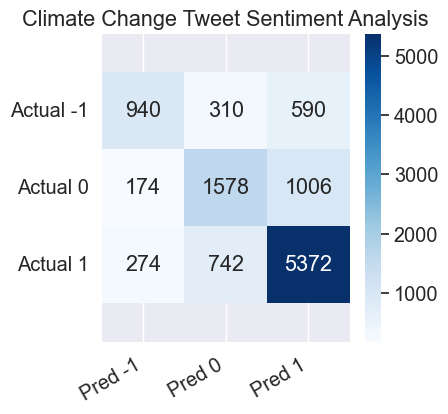

In [51]:
# Logistic Regression
model = LogisticRegression()
X_test, y_test, y_predicted, lrScoreDict = modelAndPredict(
    vectorizedTweets, df_updated["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)


*** LogisticRegression ***
Accuracy:  0.7028035681776806
Precision: 0.7020874515957355
Recall:    0.7028035681776806
F1:        0.6840711097935984



[[ 754  290  790]
 [  73 1234 1430]
 [ 108  574 5733]]


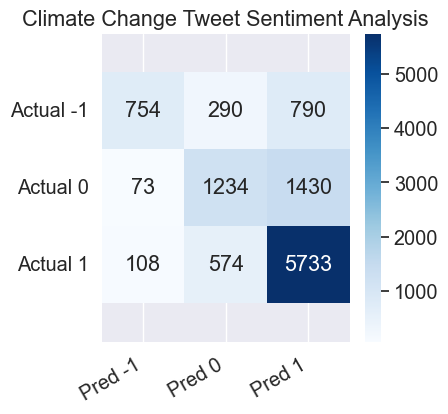

In [52]:
X_test, y_test, y_predicted, lrScoreDict2 = modelAndPredict(
    vectorizedTweets2, df_updated["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Tri-gram Logistic Regression



*** LogisticRegression ***
Accuracy:  0.6802293828509012
Precision: 0.6821824571869685
Recall:    0.6802293828509012
F1:        0.6486924812521648



[[ 582  215 1006]
 [  60 1010 1673]
 [  89  470 5881]]


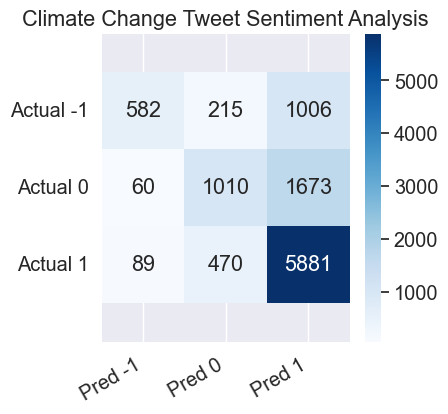

In [53]:
X_test, y_test, y_predicted, lrScoreDict3 = modelAndPredict(
    vectorizedTweets3, df_updated["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Bi-Gram & Tri-Gram Logistic Regression

Note that I was not able to vectorize data ranging from 1 to 3-gram due to memory issue on my device.



*** LogisticRegression ***
Accuracy:  0.705716366284362
Precision: 0.7042587676116665
Recall:    0.705716366284362
F1:        0.6864918524673793



[[ 737  268  790]
 [  80 1282 1446]
 [ 118  531 5734]]


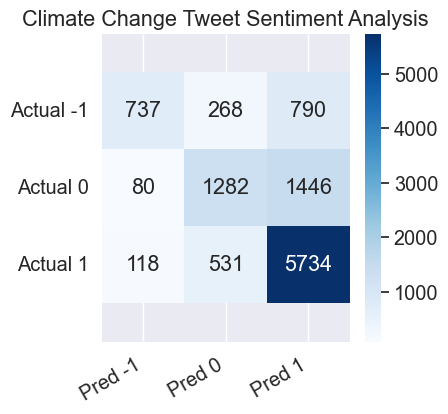

In [54]:
X_test, y_test, y_predicted, lrScoreDict23 = modelAndPredict(
    vectorizedTweets23, df_updated["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### N-gram Comparisons

We have built different vectorized sentences using different ranges of N-grams (1, 2, 3, and 2 to 3). Each of them was fed to a logistic regression model and evaluated based on classification scores such as accuracy, precision, recall and F1. In this section, we will compare all the scores and see what N-gram has worked the best.


In [55]:
lsScoreDf = pd.DataFrame(lrScoreDict, index=["-"])
lsScoreDf2 = pd.DataFrame(lrScoreDict2, index=["Bi-gram"])
lsScoreDf3 = pd.DataFrame(lrScoreDict3, index=["Tri-gram"])
lsScoreDf23 = pd.DataFrame(lrScoreDict23, index=["Bi-gram and Tri-gram"])

lsScoreComparisonDf = pd.concat([lsScoreDf, lsScoreDf2, lsScoreDf3, lsScoreDf23])
lsScoreComparisonDf

,accuracy,recall,precision,f1
-,0.718187,0.718187,0.712339,0.712345
Bi-gram,0.702804,0.702804,0.702087,0.684071
Tri-gram,0.680229,0.680229,0.682182,0.648692
Bi-gram and Tri-gram,0.705716,0.705716,0.704259,0.686492


Logistic regression has worked the best when no N-gram was used to vectorize the sentences. Let's see if we can improve the model even further using different classification models.


## 2. Decision Tree


In [56]:
model = DecisionTreeClassifier(max_depth=20)


*** DecisionTreeClassifier ***
Accuracy:  0.6217003458947752
Precision: 0.6253158538190021
Recall:    0.6217003458947752
F1:        0.5431402040448499



[[ 373  109 1362]
 [  61  382 2368]
 [  95  161 6075]]


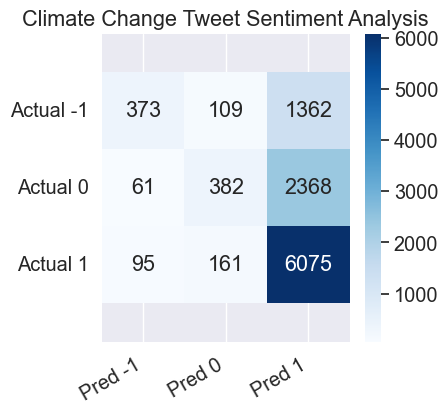

In [57]:
X_test, y_test, y_predicted, treeScoreDict = modelAndPredict(
    vectorizedTweets, df_updated["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

## 3. Random Forest Classifier


In [58]:
model = RandomForestClassifier()


*** RandomForestClassifier ***
Accuracy:  0.712998361551065
Precision: 0.722351168632418
Recall:    0.712998361551065
F1:        0.6870033624977372



Accuracy:  0.712998361551065
Precision: 0.722351168632418
Recall:    0.712998361551065
F1:        0.6870033624977372



[[ 641  212  893]
 [  66 1237 1546]
 [  47  389 5955]]
[[ 641  212  893]
 [  66 1237 1546]
 [  47  389 5955]]


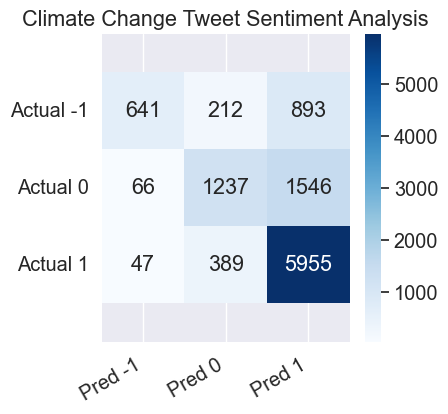

In [59]:
X_test, y_test, y_predicted, rfScoreDict = modelAndPredict(
    vectorizedTweets, df_updated["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

## 4. Extra Trees Classifier


In [60]:
model = ExtraTreesClassifier()


*** ExtraTreesClassifier ***
Accuracy:  0.7160932095394138
Precision: 0.7209596855153259
Recall:    0.7160932095394138
F1:        0.6950512300079429



[[ 724  252  864]
 [  74 1331 1403]
 [  78  448 5812]]


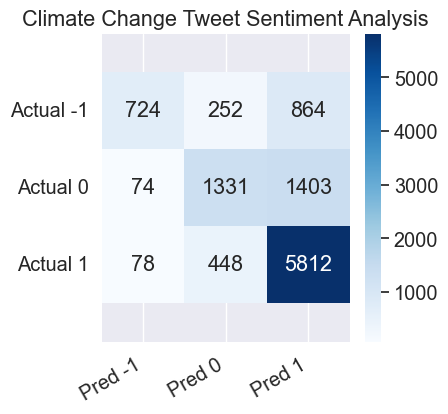

In [61]:
X_test, y_test, y_predicted, xtreeScoreDict = modelAndPredict(
    vectorizedTweets, df_updated["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

## 5. K Neighbors Classifier


In [62]:
model = KNeighborsClassifier()


*** KNeighborsClassifier ***
Accuracy:  0.4769706899690515
Precision: 0.6229173697454921
Recall:    0.4769706899690515
F1:        0.4826732705208466



[[ 458 1044  311]
 [  90 2171  513]
 [ 212 3576 2611]]


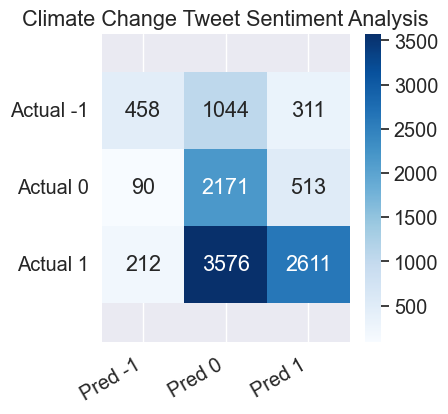

In [63]:
X_test, y_test, y_predicted, knnScoreDict = modelAndPredict(
    vectorizedTweets, df_updated["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

## 6. Linear Support Vector Classifier (SVC)


In [64]:
model = SVC()


*** SVC ***
Accuracy:  0.7278354269069726
Precision: 0.7306471841147424
Recall:    0.7278354269069726
F1:        0.7063910687678008



[[ 700  230  854]
 [  69 1316 1359]
 [ 101  377 5980]]


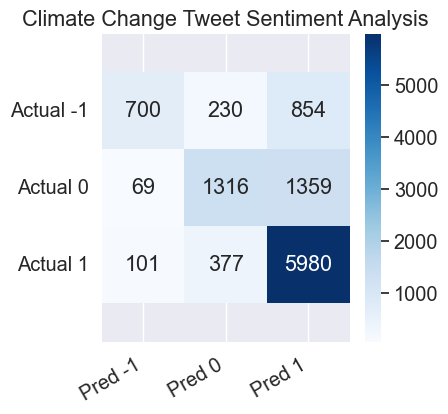

In [65]:
X_test, y_test, y_predicted, svcScoreDict = modelAndPredict(
    vectorizedTweets, df_updated["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

## 7. Ridge Classifier


In [66]:
model = RidgeClassifier()


*** RidgeClassifier ***
Accuracy:  0.7122701620243946
Precision: 0.704272984629211
Recall:    0.7122701620243946
F1:        0.7050755322742857



[[ 925  285  571]
 [ 193 1445 1114]
 [ 259  739 5455]]


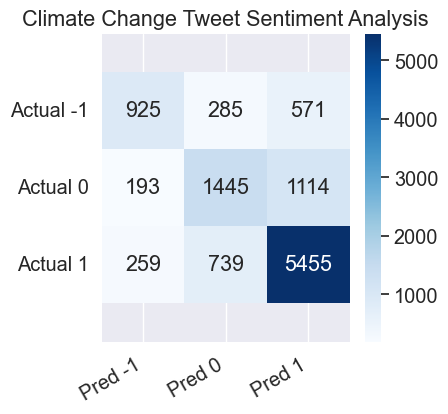

In [67]:
X_test, y_test, y_predicted, ridgeScoreDict = modelAndPredict(
    vectorizedTweets, df_updated["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

# Model Comparisons


In [68]:
lrScoreDf = pd.DataFrame(lrScoreDict, index=["Logistic Regression"])
treeScoreDf = pd.DataFrame(treeScoreDict, index=["Decision Tree"])
rfScoreDf = pd.DataFrame(rfScoreDict, index=["Random Forest Classification"])
xtreeScoreDf = pd.DataFrame(xtreeScoreDict, index=["Extra Trees Classification"])
knnScoreDf = pd.DataFrame(knnScoreDict, index=["K Neighbors Classification"])
svcScoreDf = pd.DataFrame(
    svcScoreDict, index=["Linear Support Vector Classifier Classification"]
)
ridgeScoreDf = pd.DataFrame(ridgeScoreDict, index=["Ridge Classification"])

clsCompDf = pd.concat(
    [
        lrScoreDf,
        treeScoreDf,
        rfScoreDf,
        xtreeScoreDf,
        knnScoreDf,
        svcScoreDf,
        ridgeScoreDf,
    ]
)

clsCompDf.sort_values(by=["accuracy", "f1"], ascending=False)

,accuracy,recall,precision,f1
Linear Support Vector Classifier Classification,0.727835,0.727835,0.730647,0.706391
Logistic Regression,0.718187,0.718187,0.712339,0.712345
Extra Trees Classification,0.716093,0.716093,0.720960,0.695051
Random Forest Classification,0.712998,0.712998,0.722351,0.687003
Ridge Classification,0.712270,0.712270,0.704273,0.705076
Decision Tree,0.621700,0.621700,0.625316,0.543140
K Neighbors Classification,0.476971,0.476971,0.622917,0.482673


**Logistic Regression** seems to be performing the best because it has the highest accuracy, recall, precision and f1 among all models. **SVC** and **Ridge Classification** are also good runner-ups.


# Binary File Export

To reuse the built model to predict other tweets, we will be saving the model as a binary file.


In [69]:
def modelAndPredict(X, target, model):
    """
    Build model and predict scores.

    :param X: X contains the stemmed and vectorized sentences.
    :param target: the sentiment rating
    :param model: selected model
    :return: X_test, y_test, and y_predicted values.
    """

    modelType = model.__class__.__name__

    # Create training set with 75% of data and test set with 25% of data.
    X_train, X_test, y_train, y_test = train_test_split(X, target, train_size=0.75)

    # Build the model with the training data.
    clfModel = model.fit(X_train, y_train)

    # save model to a pickle file
    # create directory for models
    if not path.exists("./model"):
        makedirs("./model")
    pickle.dump(
        clfModel, open(f"./model/climate_change_tweet_sentiment_{modelType}.dat", "wb")
    )

    # load model
    loadedModel = pickle.load(
        open(f"./model/climate_change_tweet_sentiment_{modelType}.dat", "rb")
    )

    clsScoreDict = evaluateModel(loadedModel, X_test, y_test, modelType)

    # Predict target values.
    y_prediction = model.predict(X_test)

    return X_test, y_test, y_prediction, clsScoreDict

In [70]:
model = LogisticRegression()


*** LogisticRegression ***
Accuracy:  0.7156380848352448
Precision: 0.7064128792172184
Recall:    0.7156380848352448
F1:        0.7065588562167666



[[ 960  250  591]
 [ 185 1399 1183]
 [ 289  626 5503]]


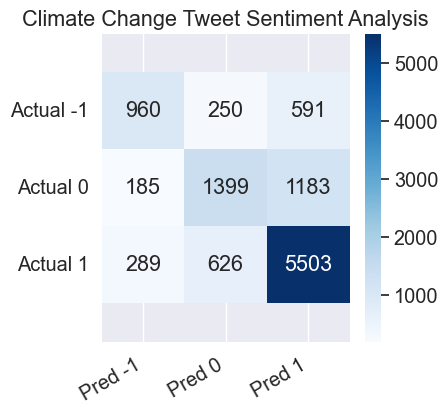

In [71]:
X_test, y_test, y_predicted, lrScoreDict = modelAndPredict(
    vectorizedTweets, df_updated["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

We also need a reference to vectors for each word found in the dataset. The word dictionary will be exported as a JSON file. Each unique word in the dataset is associated with its vector value.


In [72]:
# with open("wordDictionary.json", "w") as fp:
#     json.dump(vectorDictionary, fp)